# Notebook use to analyse one specific file.

You can click `shift` + `enter` to run one cell, you can also click run in top menu.
To run all the cells, you can click `kernel` and `Restart and run all` in the top menu.

In [1]:
import time
tp1 = time.time()

In [2]:
# Some magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
# Ignore warnings in notebook
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Matplotlib to plot the data
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
plt.rcParams['figure.figsize'] = 8,8
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [5]:
# Some module needed in the notebook
import numpy as np
import javabridge
import bioformats
from itkwidgets import view
from sklearn.externals import joblib

### The following path should direct to the folder "utils", on Window env it should have slash " / " and not backslash " \ " . 

In [6]:
# Create a temporary python PATH to the module that we are using for the analysis
import sys
sys.path.insert(0, "/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/ChromosomeDetectionChloe/utils")

In [7]:
from chromosome_dsb import *

In [8]:
# Need to create a javabridge to use bioformats to open proprietary format
javabridge.start_vm(class_path=bioformats.JARS)

### In the path_data variable you should enter the path to your data:

In [9]:
path_data = '/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/data_chloe/test_batch/exp1/'

In [10]:
position, time_point = load_data.stage_position(path_data)

# Set Parameters

In [11]:
# Size kernel for background substraction, should be a little larger than the object of interest
back_sub_FOCI = 5
back_sub_Nucleus = 20
# LOCI detection:
# Smallest object (in pixels) to be detected
smaller = 1
# Largest object to be detected
largest = 5
# Threshold above which to look for
threshold = 18000    

# Find "Skeleton" of gonad

In [12]:
skelete = load_data.skeleton_coord(position,time_point)

# Load Image

### In the path_img you can enter the name of your specific image "/....dv"

In [13]:
path_img = '/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/data_chloe/AV956_002/2019-05-30_CG006_chHTP3_rbGFP_AV956_002_visit_11_D3D_ALX.dv'

In [14]:
image, meta, directory = load_data.load_bioformats(path_img)

# Plot "Skeleton" of gonad

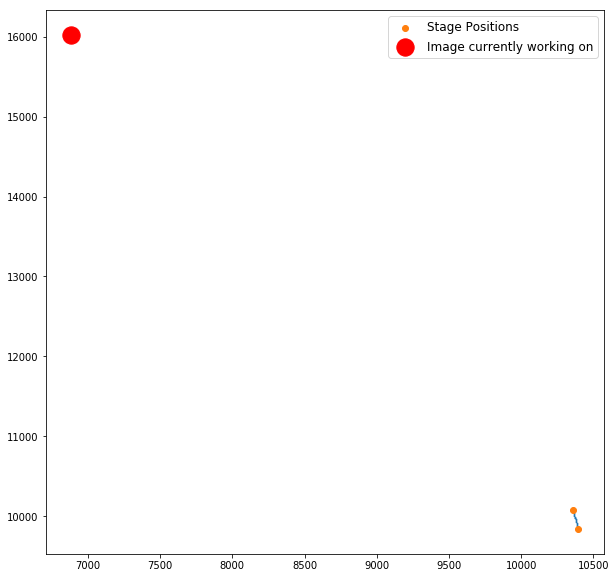

In [15]:
data = np.concatenate((position,time_point[:, np.newaxis]), axis=1)
sort_data = data[np.argsort(data[:,2])]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(skelete[:,0], skelete[:,1], s=0.5)
stage_pos = ax.scatter(sort_data[:,0], sort_data[:,1])
working_on = ax.scatter(meta["PositionX"], meta["PositionY"], s=300, color = "r")
plt.legend([stage_pos, working_on], ["Stage Positions", 
                                     "Image currently working on"],
                                      loc=0,fontsize='large')

In [16]:
img = image[:,:,:,2]

### Optionally you can visualyze your data

In [17]:
#view(visualization.convert_view(img))

# Find the nucleus in the image

### First need to load the classifier (clf) and scaler.

In [18]:
clf = joblib.load("/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/ChromosomeDetectionChloe/clf_scaler/clf")
scaler = joblib.load("/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/ChromosomeDetectionChloe/clf_scaler/scaler")

In [19]:
tp_1 = time.time()
result = search.rolling_window(img, clf, scaler)
tp_2 = time.time()
print(tp_2-tp_1)

235.13968062400818


In [20]:
bbox_ML = search.non_max_suppression(result, probaThresh=0.8, overlapThresh=0.3)

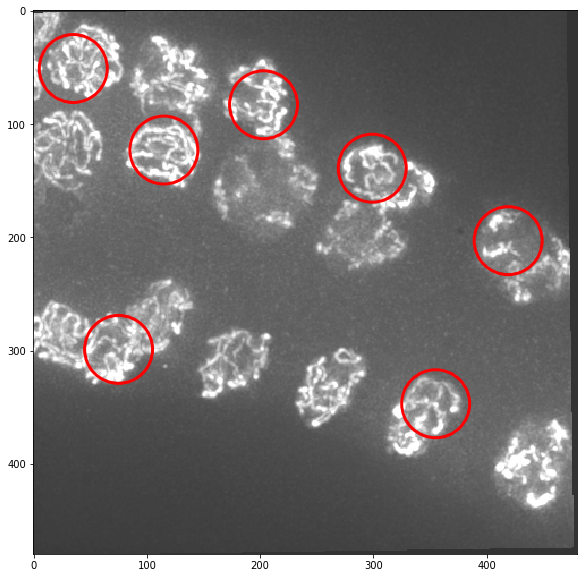

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.amax(img,axis=0), vmax=img.max()/2, alpha = 0.8)
for coord in bbox_ML:
    circles1 = patches.Circle((coord[0]+35,coord[1]+35),30, linewidth=3,edgecolor='r',facecolor='none')
    ax.add_patch(circles1)

# Background Substraction

In [22]:
FOCI_ch, _ = img_analysis.background_correct(image, ch=1, size=back_sub_FOCI)
Nucleus_ch, _ = img_analysis.background_correct(image, ch=2, size=back_sub_Nucleus)

In [23]:
visualization.plot_background(image, FOCI_ch, Nucleus_ch)

interactive(children=(IntSlider(value=100, description='pos', max=479), Dropdown(description='channel', option…

# Finding the Blobs/FOCI

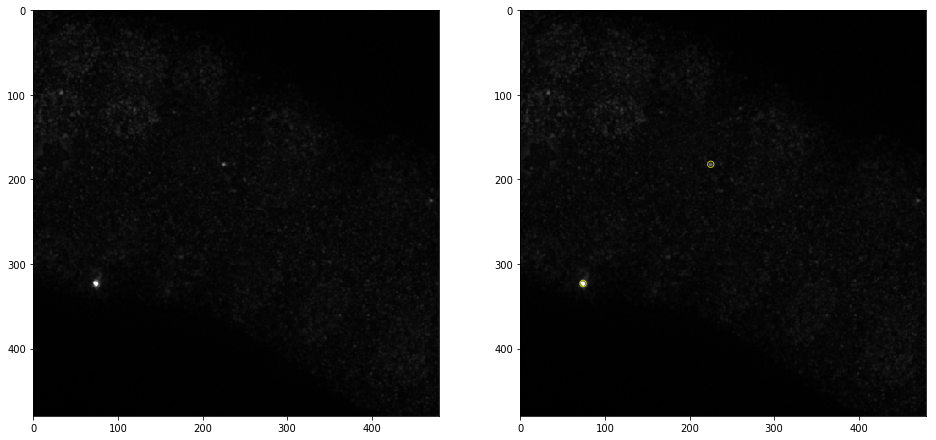

In [24]:
blobs = img_analysis.find_blob(FOCI_ch, meta, directory, smaller = smaller, 
                               largest = largest, thresh = threshold,
                               plot=True)

# Binarization of the Channel with nucleus

In [25]:
binary = img_analysis.binarization(Nucleus_ch)

### Optionaly, you can visualyze the result of the binarization

In [26]:
#view(visualization.convert_view(binary))

# Load the position of the different nucleus

In [27]:
#bbox_ML = np.load("/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/13/bbox_3D.npy")

# Mask FOCI that are not on the nucleus

In [28]:
masked = search.find_foci(blobs, FOCI_ch, Nucleus_ch, binary, bbox_ML)

# Mask FOCI that are not on a nucleus found by the Machine Learning

In [29]:
res, bb_mask = search.binary_select_foci(bbox_ML, Nucleus_ch, masked)

# Find and remove FOCI that were counted twice

In [30]:
num, cts, dup_idx, mask = search.find_duplicate(res, bb_mask)

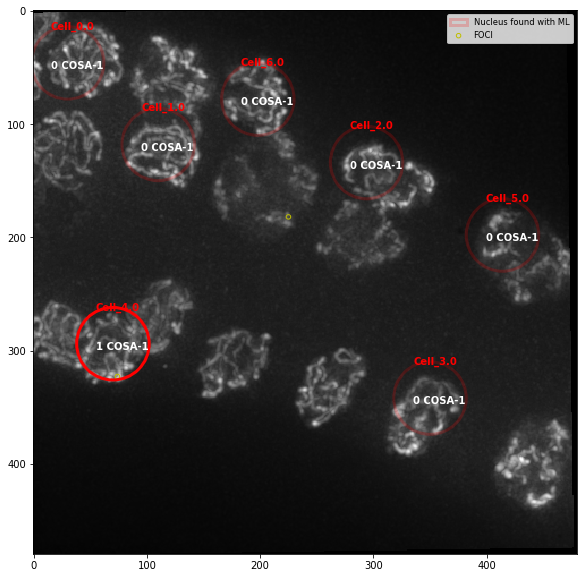

In [31]:
visualization.plot_result(img, blobs, bbox_ML,\
                          cts, num, meta, directory, save = False)

In [32]:
dist_tip = img_analysis.distance_to_tip(bbox_ML, skelete, meta)

In [33]:
chro_pos = np.squeeze(np.dstack((bbox_ML[:,0]+35,
                          bbox_ML[:,1]+35, bbox_ML[:,4])))

In [34]:
df = img_analysis.final_table(meta, bbox_ML,  \
                         dist_tip, cts, num, \
                         directory, save = False)

In [35]:
df

,Image ID,Chromosome position x,Chromosome position y,Chromosome position z,Chromosome position x in stage coordinate,Chromosome position y in stage coordinate,distance from tip in um,Numbers of FOCI,cell number on image
0,11,51,35,84,6867,16035,6916,0,0.0
1,11,123,115,24,6874,16029,6907,0,1.0
2,11,139,299,52,6889,16028,6899,0,2.0
3,11,347,355,64,6893,16011,6882,0,3.0
4,11,299,75,64,6871,16015,6896,1,4.0
5,11,203,419,84,6898,16023,6890,0,5.0
6,11,83,203,44,6881,16033,6907,0,6.0


In [38]:
to_save = {'back_sub_ch1' : back_sub_FOCI,
           'back_sub_ch2' : back_sub_Nucleus,
           'small_object' : smaller,
           'large_object' : largest,
           'threshold' : threshold}

log.log_file(directory, meta, **to_save)

In [ ]:
tp2 = time.time()

In [ ]:
print("It took {}sec".format(int(tp2-tp1)))